In [1]:
import tarfile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
tarfname = "data/sentiment.tar.gz"

In [3]:
tar = tarfile.open(tarfname, "r:gz")
trainname = "train.tsv"
devname = "dev.tsv"
for member in tar.getmembers():
    if 'train.tsv' in member.name:
        trainname = member.name
    elif 'dev.tsv' in member.name:
        devname = member.name

In [4]:
member = tar.getmember(trainname)
tf = tar.extractfile(member)
data = []
labels = []
for line in tf:
    line = line.decode("utf-8")
    (label,text) = line.strip().split("\t")
    labels.append(label)
    data.append(text)
train_data,train_labels=data, labels

In [5]:
member = tar.getmember(devname)
tf = tar.extractfile(member)
data = []
labels = []
for line in tf:
    line = line.decode("utf-8")
    (label,text) = line.strip().split("\t")
    labels.append(label)
    data.append(text)
dev_data,dev_labels=data, labels

In [6]:
count_vect = CountVectorizer()
trainX = count_vect.fit_transform(train_data)
devX = count_vect.transform(dev_data)

In [7]:
le = preprocessing.LabelEncoder()
le.fit(train_labels)
target_labels = le.classes_
trainy = le.transform(train_labels)
devy = le.transform(dev_labels)

In [8]:
tar.close()

In [9]:
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)
cls.fit(trainX, trainy)
def evaluate(X, yt, cls, name='data'):
    """Evaluated a classifier on the given labeled data using accuracy."""
    yp = cls.predict(X)
    acc = metrics.accuracy_score(yt, yp)
    print("  Accuracy on %s  is: %s" % (name, acc))
    #return(acc)

In [10]:
evaluate(trainX, trainy, cls, 'train')
evaluate(devX, devy, cls, 'dev')

  Accuracy on train  is: 0.9821038847664775
  Accuracy on dev  is: 0.777292576419214


# 2.1 Guided Feature Engineering

In [11]:
def evaluate1(X, yt, cls, name='data'):
    """Evaluated a classifier on the given labeled data using accuracy."""
    from sklearn import metrics
    yp = cls.predict(X)
    acc = metrics.accuracy_score(yt, yp)
    #print("  Accuracy on %s  is: %s" % (name, acc))
    return(acc)

In [12]:
regularizer=[0.01,0.1,1,10,100]
ngram=7
accuraciest=[]
accuraciesd=[]
for j in regularizer:
    valuest=[]
    valuesd=[]
    for i in range(1,ngram):
        #print(f"Th value of ngram={i},value of regularizer={j}")
        vectorizer = TfidfVectorizer(ngram_range=(1, i))
        XTrain = vectorizer.fit_transform(train_data)
        devTrain=vectorizer.transform(dev_data)
        tfidf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000,C=j)
        tfidf.fit(XTrain, trainy)
        valuest.append(round(evaluate1(XTrain, trainy, tfidf, 'train'),8))
        valuesd.append(round(evaluate1(devTrain, devy, tfidf, 'dev'),8))
    accuraciest.append(valuest)
    accuraciesd.append(valuesd)

In [13]:
accuraciestpd = np.array(accuraciest)
print("Accuracies on Train")
df = pd.DataFrame(accuraciest,     index=["C=0.01","C=0.1","C=1","C=10","C=100"],
                 columns=['1-gram', '2-gram','3-gram','4-gram','5-gram','6-gram'])
# for i in range(len(accuraciest)):
#     print("C=",regularizer[i],end="\t\t")
#     for j in range(len(accuraciest[0])):
#         print(j,"-gram",accuraciest[i][j],end=" ")
#     print()
df

Accuracies on Train


,1-gram,2-gram,3-gram,4-gram,5-gram,6-gram
C=0.01,0.794849,0.857049,0.909865,0.946093,0.969227,0.981449
C=0.1,0.816674,0.877128,0.923178,0.953950,0.975557,0.984286
C=1,0.902008,0.957006,0.980140,0.990615,0.997599,0.998472
C=10,0.985159,1.000000,1.000000,1.000000,1.000000,1.000000
C=100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
df.to_csv(r'result-2-1_train.csv', header=True)

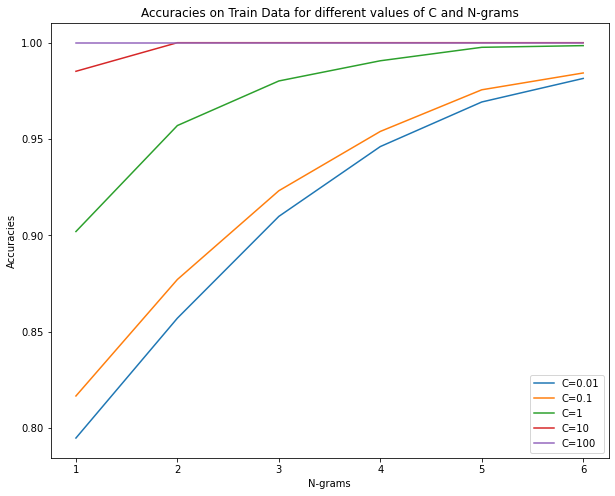

In [15]:
fig=plt.figure(figsize=(10,8))
x=[1,2,3,4,5,6]
plt.plot(x,accuraciest[0],label="C=0.01")
plt.plot(x,accuraciest[1],label="C=0.1")
plt.plot(x,accuraciest[2],label="C=1")
plt.plot(x,accuraciest[3],label="C=10")
plt.plot(x,accuraciest[4],label="C=100")
plt.xlabel("N-grams")
plt.ylabel("Accuracies")
plt.legend()
plt.title("Accuracies on Train Data for different values of C and N-grams")
plt.show()

In [16]:
accuraciesdpd = np.array(accuraciesd)
print("Accuracies on Dev")
df = pd.DataFrame(accuraciesd,     index=["C=0.01","C=0.1","C=1","C=10","C=100"],
                 columns=['1-gram', '2-gram','3-gram','4-gram','5-gram','6-gram'])
# for i in range(len(accuraciest)):
#     print("C=",regularizer[i],end="\t\t")
#     for j in range(len(accuraciest[0])):
#         print(j,"-gram",accuraciest[i][j],end=" ")
#     print()
df

Accuracies on Dev


,1-gram,2-gram,3-gram,4-gram,5-gram,6-gram
C=0.01,0.742358,0.751092,0.751092,0.751092,0.746725,0.742358
C=0.1,0.748908,0.751092,0.746725,0.744541,0.744541,0.744541
C=1,0.766376,0.770742,0.770742,0.762009,0.759825,0.759825
C=10,0.790393,0.788210,0.790393,0.783843,0.779476,0.775109
C=100,0.781659,0.792576,0.794760,0.777293,0.779476,0.779476


In [17]:
df.to_csv(r'result-2-1_dev.csv', header=True)

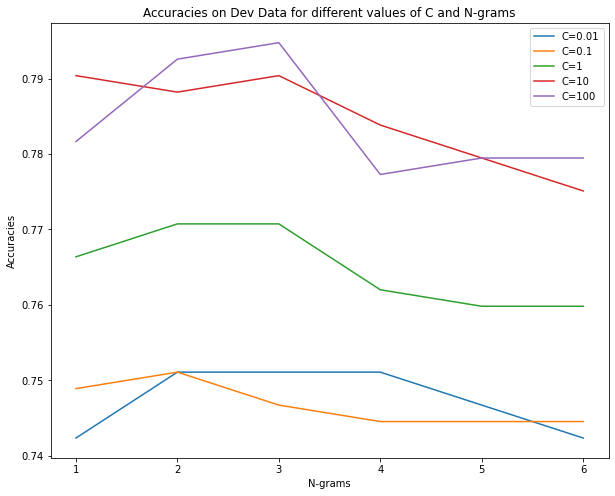

In [18]:
fig=plt.figure(figsize=(10,8))
x=[1,2,3,4,5,6]
plt.plot(x,accuraciesd[0],label="C=0.01")
plt.plot(x,accuraciesd[1],label="C=0.1")
plt.plot(x,accuraciesd[2],label="C=1")
plt.plot(x,accuraciesd[3],label="C=10")
plt.plot(x,accuraciesd[4],label="C=100")
plt.xlabel("N-grams")
plt.ylabel("Accuracies")
plt.legend()
plt.title("Accuracies on Dev Data for different values of C and N-grams")
plt.show()